# 1. Import Library

In [ ]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(10)

# 資料準備

In [ ]:
(x_img_train,y_label_train),(x_img_test,y_label_test)=cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


自動下載data set

In [ ]:
print("train data:",'images:',x_img_train.shape,
      " labels:",y_label_train.shape) 
print("test  data:",'images:',x_img_test.shape ,
      " labels:",y_label_test.shape) 

train data: images: (50000, 32, 32, 3)  labels: (50000, 1)
test  data: images: (10000, 32, 32, 3)  labels: (10000, 1)


順序標記訓練集和測試集的(資料數量,形狀和通道數量)
例:(50000筆,像素32*32,RGB圖片通道為3)

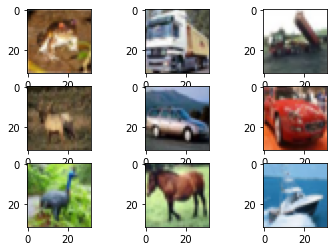

In [ ]:
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_img_train[i])
plt.show()

# Data Augmentation

In [ ]:
image_gen_train = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)
image_gen_train.fit(x_img_train)

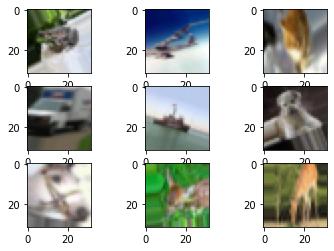

In [ ]:
# see example augmentation images
for X_batch, y_batch in image_gen_train.flow(x_img_train, y_label_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [ ]:
# x_img_train_normalize = x_img_train.astype('float32') / 255.0
# x_img_test_normalize = x_img_test.astype('float32') / 255.0
x_img_train = x_img_train.astype('float32')
x_img_test = x_img_test.astype('float32')
mean=np.mean(x_img_train)
std=np.std(x_img_train)
x_img_train_normalize=(x_img_train-mean)/std
x_img_test_normalize=(x_img_test-mean)/std

In [ ]:
print("train data:",'images:',x_img_train.shape,
      " labels:",y_label_train.shape) 
print("test  data:",'images:',x_img_test.shape ,
      " labels:",y_label_test.shape) 

train data: images: (50000, 32, 32, 3)  labels: (50000, 1)
test  data: images: (10000, 32, 32, 3)  labels: (10000, 1)


因為圖片像素數據以0到255表達，因此將數據(圖片)除以255,進行標準化,提高準確率

In [ ]:
from keras.utils import np_utils
y_label_train_OneHot = np_utils.to_categorical(y_label_train)
y_label_test_OneHot = np_utils.to_categorical(y_label_test)
# # labels
# num_classes=10
# y_train = k.utils.to_categorical(y_train, num_classes)
# y_test = k.utils.to_categorical(y_test, num_classes)

將圖片預先做好的標籤欄位轉換為Onehot encoding,方便後續繪制圖表時直接代入標籤文字

In [ ]:
y_label_test_OneHot.shape

(10000, 10)

執行結果,數量為被處理的圖片數量

# 建立模型

In [ ]:
# ref:　https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-
# build and compile the model  (roughly following the VGG paper)

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
# adm=Adam(lr=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# opt=adm
drop_dense=0.5
drop_conv=0
num_classes=10

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

# 載入之前訓練的模型

In [ ]:
try:
    model.load_weights("SaveModel/cifarCnnModelnew1.h5")
    print("載入模型成功!繼續訓練模型")
except :    
    print("載入模型失敗!開始訓練一個新模型")

載入模型失敗!開始訓練一個新模型


# 訓練模型

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

設定損失函數,在深度學習中通常會使用cross entropy交叉熵,訓練效果較好

In [ ]:
# train_history=model.fit(x_img_train_normalize, y_label_train_OneHot,
#                         validation_split=0.1,
#                         epochs=100, batch_size=64, verbose=1)     

# validation_data=(x_img_train_normalize, y_label_train_OneHot)
# steps_per_epoch = len(x_img_train_normalize) / 128, 

validation_split=0.1
x_img_val_normalize = x_img_train_normalize[:int(x_img_train_normalize.shape[0] * validation_split)]
y_label_val_OneHot = y_label_train_OneHot[:int(y_label_train_OneHot.shape[0] * validation_split)]
x_img_train_normalize = x_img_train_normalize[int(x_img_train_normalize.shape[0] * validation_split):]
y_label_train_OneHot = y_label_train_OneHot[int(y_label_train_OneHot.shape[0] * validation_split):]

print(x_img_val_normalize.shape)
print(y_label_val_OneHot.shape)
print(x_img_train_normalize.shape)
print(y_label_train_OneHot.shape)

train_history = model.fit(image_gen_train.flow(x_img_train_normalize, y_label_train_OneHot, batch_size=128),
                     epochs=100, validation_data=(x_img_val_normalize, y_label_val_OneHot), verbose=1)     

(5000, 32, 32, 3)
(5000, 10)
(45000, 32, 32, 3)
(45000, 10)
Epoch 1/100
352/352 [==============================] - 51s 108ms/step - loss: 2.0466 - accuracy: 0.3332 - val_loss: 1.5772 - val_accuracy: 0.4336
Epoch 2/100
352/352 [==============================] - 36s 103ms/step - loss: 1.5700 - accuracy: 0.4357 - val_loss: 1.3163 - val_accuracy: 0.5370
Epoch 3/100
352/352 [==============================] - 36s 103ms/step - loss: 1.4041 - accuracy: 0.4941 - val_loss: 1.1525 - val_accuracy: 0.5930
Epoch 4/100
352/352 [==============================] - 38s 109ms/step - loss: 1.3010 - accuracy: 0.5340 - val_loss: 1.0750 - val_accuracy: 0.6296
Epoch 5/100
352/352 [==============================] - 36s 103ms/step - loss: 1.2169 - accuracy: 0.5679 - val_loss: 1.2095 - val_accuracy: 0.5926
Epoch 6/100
352/352 [==============================] - 37s 105ms/step - loss: 1.1678 - accuracy: 0.5858 - val_loss: 0.8516 - val_accuracy: 0.7108
Epoch 7/100
352/352 [==============================] - 36s 103ms

輸入圖像標籤文字

validatiom split:訓練集和測試集的比例,這次為50000:10000,所以是0.2

epochs:訓練週期10次

batch size:每批次輸入128張圖片

In [ ]:
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

設定圖表欄位和格式

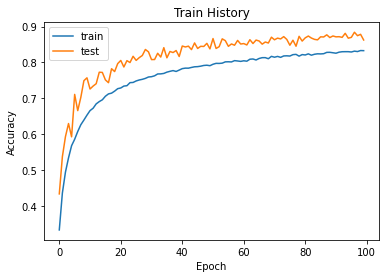

In [ ]:
show_train_history('accuracy','val_accuracy')

accuracy:訓練時的準確率

val accuracy:驗證時的準確率

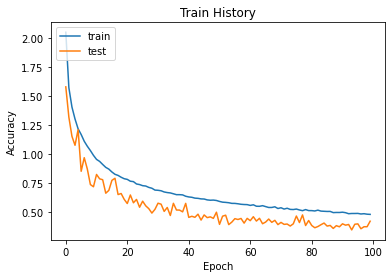

In [ ]:
show_train_history('loss','val_loss')

loss:訓練時的誤差

val accuracy:驗證時的誤差

# 評估模型準確率

In [ ]:
scores = model.evaluate(x_img_test_normalize, 
                        y_label_test_OneHot, verbose=0)
scores[1]

0.8543000221252441

# 進行預測

In [ ]:
prediction=np.argmax(model.predict(x_img_test_normalize), axis=-1)

In [ ]:
prediction[:10]

array([3, 8, 1, 0, 6, 6, 1, 6, 3, 1])

# 查看預測結果

In [ ]:
label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
            5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [ ]:
import matplotlib.pyplot as plt
def plot_images_labels_prediction(images,labels,prediction,
                                  idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx],cmap='binary')
                
        title=str(i)+','+label_dict[labels[i][0]]
        if len(prediction)>0:
            title+='=>'+label_dict[prediction[i]]
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

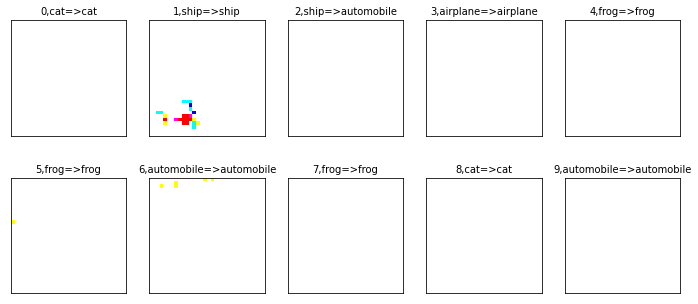

In [ ]:
plot_images_labels_prediction(x_img_test,y_label_test,
                              prediction,0,10)

# 查看預測機率

In [ ]:
Predicted_Probability=model.predict(x_img_test_normalize)

In [ ]:
def show_Predicted_Probability(y,prediction,
                               x_img,Predicted_Probability,i):
    print('label:',label_dict[y[i][0]],
          'predict:',label_dict[prediction[i]])
    plt.figure(figsize=(2,2))
    plt.imshow(np.reshape(x_img_test[i],(32, 32,3)))
    plt.show()
    for j in range(10):
        print(label_dict[j]+
              ' Probability:%1.9f'%(Predicted_Probability[i][j]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: cat predict: cat


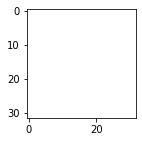

airplane Probability:0.000001595
automobile Probability:0.000438354
bird Probability:0.000073385
cat Probability:0.998456359
deer Probability:0.000001903
dog Probability:0.000715442
frog Probability:0.000205834
horse Probability:0.000001183
ship Probability:0.000004816
truck Probability:0.000101175


In [ ]:
show_Predicted_Probability(y_label_test,prediction,
                           x_img_test,Predicted_Probability,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label: airplane predict: airplane


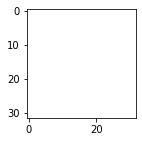

airplane Probability:0.882827938
automobile Probability:0.043008082
bird Probability:0.002016423
cat Probability:0.000868324
deer Probability:0.000030905
dog Probability:0.000009434
frog Probability:0.000003009
horse Probability:0.000036703
ship Probability:0.053290583
truck Probability:0.017908478


In [ ]:
show_Predicted_Probability(y_label_test,prediction,
                           x_img_test,Predicted_Probability,3)

# confusion matrix

In [ ]:
prediction.shape

(10000,)

建立混淆矩陣時結果資據必須為1維陣列,如果括號有多於一筆數據,則必須先進行數據處理

In [ ]:
y_label_test.shape

(10000, 1)

執行結果顯示已轉換為1維陣列

In [ ]:
y_label_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

In [ ]:
y_label_test.reshape(-1)

array([3, 8, 8, ..., 5, 1, 7], dtype=uint8)

In [ ]:
import pandas as pd
print(label_dict)
pd.crosstab(y_label_test.reshape(-1),prediction,
            rownames=['label'],colnames=['predict'])

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,870,25,7,10,6,0,4,8,17,53
1,2,944,0,1,0,0,0,0,1,52
2,56,9,750,35,39,13,54,19,3,22
3,7,10,23,747,25,53,54,22,11,48
4,7,2,29,16,842,8,40,44,2,10
5,7,6,15,115,18,734,43,25,5,32
6,4,6,7,9,8,1,945,3,3,14
7,9,7,7,12,14,15,8,896,2,30
8,49,41,4,1,1,0,4,0,865,35


匯入pandas模組

reshape(-1)轉換1維陣列

測試資料的預測結果

設定行的名稱label

設定列的名稱是predict

In [ ]:
print(label_dict)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


# Save model to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

# Save model to JSON

In [ ]:
model_json = model.to_json()
with open("/content/SaveModel/cifarCnnModelnew.json", "w") as json_file:
    json_file.write(model_json)

# Save Weight to h5 

In [ ]:
model.save_weights("/content/drive/MyDrive/Colab Notebooks/SaveModel/cifarCnnModelnew.h5")
print("Saved model to disk")